In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# utils_1D.py con
from utils_1D import Data, sense, FNN, ONet, save_object, load_object, x_train_data, plot_2D

#import tensorflow_probability as tfp

In [2]:
xd = [-1, 1.]  # domain
tao = 4E-2     # time step
k = 1.         # physcial constant

# training data for u: random distribution by gaussian process
num_sensor_in = 100  # number of discretized points of u (sensors)
num_sensor_out = 20  # number of output of brach network
# a list of length scales of gaussian process, a random draw from this list is used for generating each training sample
length_scale_list = [0.2] #0.2 
num_train = 4000
num_test = 1000

#data_sensor = Data(xd, num_sensor_in, num_sensor_out, length_scale_list, num_train, num_test)
fu = lambda u: 0.5*k*u**2


In [3]:
# save_object(data_sensor, 'Data/1D_Relax-T4000_T1000.pkl')
data_sensor = load_object('Data/1D_Relax-T4000_T1000.pkl')

2023-08-15 13:07:28.561291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2588 MB memory:  -> device: 0, name: NVIDIA T400 4GB, pci bus id: 0000:d5:00.0, compute capability: 7.5


In [4]:
u_train = sense(data_sensor.u_train, num_sensor_in) # downsample
y_train = data_sensor.solve(u_train, k, tao)        # ground truth

u_test = sense(data_sensor.u_test, num_sensor_in)
y_test = data_sensor.solve(u_test, k, tao)

In [5]:
sample_size = 20
n_interval = int(num_sensor_in / sample_size)
u_train_sample = u_train[:, ::n_interval]
u_test_sample = u_test[:, ::n_interval]

In [6]:
# training data
Nx = num_sensor_in
X = x_train_data(Nx)

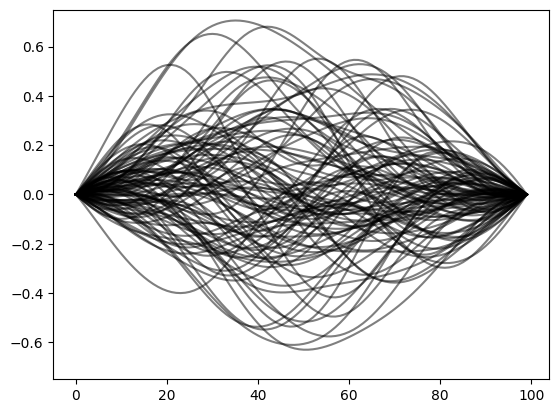

In [7]:
for i in range(100):
    plt.plot(u_train[i], 'k', linewidth=1.5, alpha=0.5)
    plt.ylim([-0.75, 0.75])

In [8]:
# Physics-informed training data
train_dataset = tf.data.Dataset.from_tensor_slices((u_train_sample, u_train))
train_dataset = train_dataset.shuffle(buffer_size=num_train).batch(256)

In [9]:
num_sensor_out = 50
n_layer_trunk = 2
n_nodes_trunk = 20
n_layer_branch = 1
n_nodes_branch = 20
Net_trunk = FNN(num_sensor_out, n_layer_trunk, n_nodes_trunk, 'relu')
Net_branch = FNN(num_sensor_out, n_layer_branch, n_nodes_branch, 'relu')
u_onet = ONet(Net_trunk, Net_branch)

In [10]:
from sklearn.metrics import r2_score, mean_squared_error

def accuracy(u, x, y_true):
    
 
    y_pred = u_onet(u, x)
 
    r2 = r2_score(y_true, y_pred)

    mse = mean_squared_error(y_true, y_pred)

    # L2 relative error
    l2_rel = np.linalg.norm((y_true - y_pred), 2)/np.linalg.norm(y_true, 2)

    # MEAN ABSOLUTE PERCENTAGE ERROR
    mape = np.mean(np.abs((y_true - y_pred) / (y_true+1e-6) ) )
    
    return r2, mse, l2_rel

In [11]:
def train_step_physics_informed(up, up0, x, optimizer):
    
    with tf.GradientTape() as g:
        
        uq = u_onet(up, x)

        loss_energy   = tf.reduce_mean( fu(uq) )*2
        loss_distance = tf.reduce_mean((uq - up0)**2)/tao/2*2
        #loss_energy   = tf.reduce_mean(tfp.math.trapz(fu(uq)))
        #loss_distance = tf.reduce_mean(tfp.math.trapz((uq - up0)**2)/tao/2)

        loss = loss_energy + loss_distance

        grads = g.gradient(loss, u_onet.trainable_variables)

        optimizer.apply_gradients(zip(grads, u_onet.trainable_variables))
        
    return loss_energy, loss_distance, loss

In [12]:
nepochs = 3000
optimizer = tf.optimizers.Adam(learning_rate=0.001)

train_err, test_err = [], []
train_acc, test_acc = [], []

#Xa = train_data(100)

for epoch in range(nepochs):

    for up, up0 in train_dataset:
        loss_energy, loss_distance, loss = train_step_physics_informed(up, up0, X, optimizer)
    #for up, uq in train_dataset3:
    #    loss = train_step_suppervised(up, uq, X)

    
    r2_train, mse_train, l2_rel_train = accuracy(u_train_sample, X, y_train)
    r2_test, mse_test, l2_rel_test = accuracy(u_test_sample, X, y_test)

    train_err.extend([mse_train])
    test_err.extend([mse_test])
    
    train_acc.extend([r2_train])
    test_acc.extend([r2_test])

    if (epoch+1) % 200 == 0:
        #r2_train, r2_test = accuracy_r2()
        print(f'Epoch :{epoch+1}, Loss:{loss:.4e}, energy:{loss_energy:.4e}, distance: {loss_distance:.4e}')
        print(f'Epoch :{epoch+1}, Loss:{loss:.4e}')
        print(f'Accuracy: Train - {r2_train:.4f},  Test - {r2_test:.4f}')

2023-08-15 13:07:46.612605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [4000,100]
	 [[{{node Placeholder/_1}}]]
2023-08-15 13:07:46.612829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [4000,100]
	 [[{{node Placeholder/_1}}]]
2023-08-15 13:07:47.237494: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1e6d22d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-15 13:07:47.237523: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA T40

Epoch :200, Loss:3.3784e-02, energy:3.1060e-02, distance: 2.7239e-03
Epoch :200, Loss:3.3784e-02
Accuracy: Train - 0.9826,  Test - 0.9828
Epoch :400, Loss:3.2871e-02, energy:3.1136e-02, distance: 1.7346e-03
Epoch :400, Loss:3.2871e-02
Accuracy: Train - 0.9939,  Test - 0.9939
Epoch :600, Loss:3.5858e-02, energy:3.4351e-02, distance: 1.5074e-03
Epoch :600, Loss:3.5858e-02
Accuracy: Train - 0.9976,  Test - 0.9976
Epoch :800, Loss:2.9460e-02, energy:2.8232e-02, distance: 1.2280e-03
Epoch :800, Loss:2.9460e-02
Accuracy: Train - 0.9980,  Test - 0.9980
Epoch :1000, Loss:3.6241e-02, energy:3.4879e-02, distance: 1.3624e-03
Epoch :1000, Loss:3.6241e-02
Accuracy: Train - 0.9981,  Test - 0.9981
Epoch :1200, Loss:3.1253e-02, energy:2.9917e-02, distance: 1.3353e-03
Epoch :1200, Loss:3.1253e-02
Accuracy: Train - 0.9981,  Test - 0.9981
Epoch :1400, Loss:3.4388e-02, energy:3.2974e-02, distance: 1.4135e-03
Epoch :1400, Loss:3.4388e-02
Accuracy: Train - 0.9982,  Test - 0.9982
Epoch :1600, Loss:3.2152e-02

In [13]:
# Suppervised training data
train_dataset_sup = tf.data.Dataset.from_tensor_slices((u_train_sample, y_train))
train_dataset_sup = train_dataset_sup.shuffle(buffer_size=num_train).batch(256)

In [14]:
def train_step_suppervised(up, uq, X, optimizer):

    with tf.GradientTape() as g:
        uq_pred = u_onet(up, X)
        loss = tf.reduce_mean((uq_pred - uq)**2)

    grads = g.gradient(loss, u_onet.trainable_variables)
    optimizer.apply_gradients(zip(grads, u_onet.trainable_variables))

    return loss

In [72]:
#train_dataset = train_dataset.shard(100, 0)

In [15]:
nepochs = 1000
optimizer = tf.optimizers.Adam(learning_rate=0.001)

train_err, test_err = [], []
train_acc, test_acc = [], []

#Xa = train_data(100)

for epoch in range(nepochs):

    #for up in train_dataset:
    #    loss_energy, loss_distance, loss = train_step(up, X)
    for up, uq in train_dataset_sup:
        loss = train_step_suppervised(up, uq, X, optimizer)

    r2_train, mse_train, l2_rel_train = accuracy(u_train_sample, X, y_train)
    
    r2_test, mse_test, l2_rel_test = accuracy(u_test_sample, X, y_test)

    train_err.extend([mse_train, r2_train])
    test_err.extend([mse_test, r2_test])
    
    train_acc.extend([r2_train])
    test_acc.extend([r2_test])


    if (epoch+1) % 100 == 0:
        #r2_train, r2_test = accuracy_r2()
        #print(f'Epoch :{epoch+1}, Loss:{loss:.4e}, energy:{loss_energy:.4e}, distance: {loss_distance:.4e}')
        print(f'Epoch :{epoch+1}, Loss:{loss:.4e}')
        print(f'Accuracy: Train - {r2_test:.4f},  Test - {l2_rel_test:.4f}')

2023-08-15 13:58:35.347679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [4000,100]
	 [[{{node Placeholder/_1}}]]
2023-08-15 13:58:35.347908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [4000,100]
	 [[{{node Placeholder/_1}}]]


Epoch :100, Loss:3.1255e-06
Accuracy: Train - 0.9993,  Test - 0.0077
Epoch :200, Loss:1.1314e-06
Accuracy: Train - 0.9994,  Test - 0.0050
Epoch :300, Loss:1.7208e-06
Accuracy: Train - 0.9994,  Test - 0.0063
Epoch :400, Loss:9.8608e-07
Accuracy: Train - 0.9995,  Test - 0.0050
Epoch :500, Loss:1.1268e-06
Accuracy: Train - 0.9995,  Test - 0.0050
Epoch :600, Loss:1.1941e-06
Accuracy: Train - 0.9995,  Test - 0.0049
Epoch :700, Loss:1.1174e-06
Accuracy: Train - 0.9995,  Test - 0.0049
Epoch :800, Loss:1.7073e-06
Accuracy: Train - 0.9995,  Test - 0.0049
Epoch :900, Loss:1.1160e-06
Accuracy: Train - 0.9995,  Test - 0.0049
Epoch :1000, Loss:8.7028e-07
Accuracy: Train - 0.9995,  Test - 0.0048


In [63]:
np.savetxt('Data/training_err_1D_NN_40.txt', train_err, fmt='%.4e')
np.savetxt('Data/testing_err_1D_NN_40.txt', test_err, fmt='%.4e')
np.savetxt('Data/r2_train_1D_NN_40.txt', train_acc, fmt='%.4e')
np.savetxt('Data/r2_test_1D_NN_40.txt', test_acc, fmt='%.4e')
#np.savetxt('Data/run_time_1D_NN.txt', run_time, fmt='%.4e')

In [25]:
up[::n_interval]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 0.        , -0.05574192, -0.10714272, -0.15630817, -0.20942096,
       -0.2639196 , -0.3032025 , -0.30307373, -0.24561208, -0.13232689,
        0.01098782,  0.14217713,  0.22167853,  0.23253526,  0.187948  ,
        0.12028924,  0.0600714 ,  0.02148049,  0.00345796, -0.00082683],
      dtype=float32)>

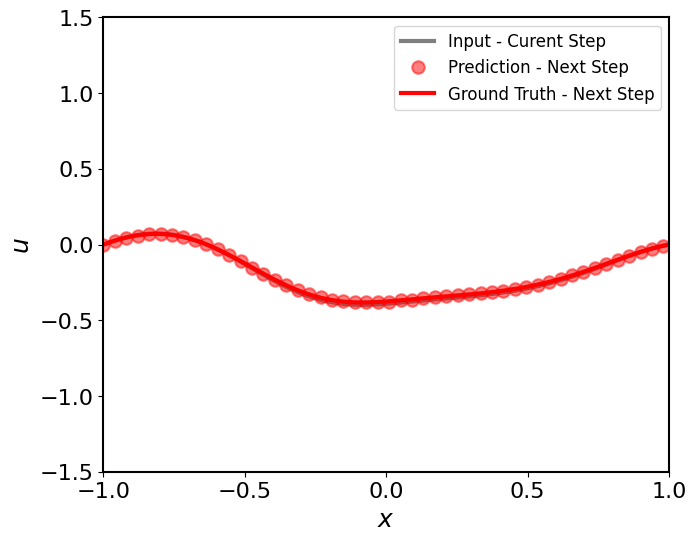

In [37]:
i=1
up = u_train[i:i+1]
#up = np.expand_dims(up, 0)
uq = u_onet(up[:,::n_interval], X)

xlim = [-1., 1.]
xticks= [-1, -0.5, 0, 0.5, 1.]
ylim = [-1.5, 1.5]
yticks = [-1.5, -1, -0.5, 0, 0.5, 1., 1.5]
xlabel = r'$\mathit{x}$'
ylabel = r'$\mathit{u}$'

fig, ax = plot_2D(xlim=xlim, ylim=ylim, xticks=xticks, yticks=yticks, xlabel=xlabel, ylabel=ylabel)

ax.plot(X[:,0], up[0], 'k', linewidth = 3, alpha=0.5, label='Input - Curent Step')
ax.plot(X[:,0], uq[0], 'ro', markevery=2, markersize=9, 
        markeredgewidth=1.5, markerfacecolor=[1, 0, 0, 0.5], label='Prediction - Next Step' )
ax.plot(X[:,0], y_train[i], 'r', linewidth = 3, alpha=0.99, label = 'Ground Truth - Next Step')
ax.legend(fontsize='large')

#plt.savefig('1D_map.png', dpi=300, transparent=True)
#plt.show()

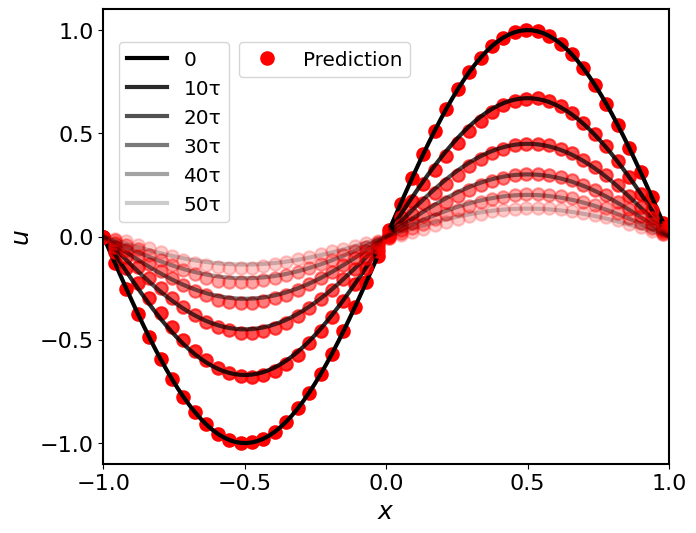

In [38]:
x0 = tf.linspace(-1, 1, 100)
f0 = tf.reshape(tf.sin(3.14*x0), (1, -1))

xlim = [-1, 1]
ylim = [-1.1, 1.1]
xticks = [-1.0, -0.5, 0, 0.5, 1.0]
yticks = xticks
xlabel = r"$\mathit{x}$"
ylabel = r"$\mathit{u}$"

fig, ax = plot_2D(xlim=xlim, ylim=ylim, xticks=xticks, yticks=yticks, xlabel=xlabel, ylabel=ylabel)

for i in range(51):

    if (i == 0):
        u_pred = f0
        
    else:   
        u_pred = u_onet(u_pred[:,::n_interval], X)

    u_exact = np.exp(-k*tao*i)*np.sin(X*np.pi)
    
    if i % 10 == 0 :

        ln1, = ax.plot(X, tf.reshape(u_pred, (-1, 1)), 'ro', markevery=2, markersize=9, 
            markeredgewidth=1.5, markerfacecolor=[1, 0, 0, 1 - 0.016*i])
        if i == 0:
            label_tao = f'{i:d}'
            ln = ln1
        else:
            label_tao = f'{i:d}' + '\u03C4'
        ln2, = ax.plot(X, u_exact, 'k', linewidth = 3, alpha=1 - 0.016*i, label = label_tao)


leg1 = ax.legend([ln], ['Prediction'], fontsize='x-large',  loc='upper right', bbox_to_anchor=(0.56, 0.95))
ax.legend(fontsize='x-large', bbox_to_anchor=(0.24, 0.95))

#ax.legend([ln1, ln2], ['Prediction', 'Ground Truth'], fontsize='large')
ax.add_artist(leg1)
# add colorbar bar on the right with custom ticks
# Create a list of transparency values for the curves
transparency_values = [1 - 0.016 * i for i in range(51)]

# Create a ScalarMappable object representing the transparency color range
#from matplotlib import cm
#cmap = cm.get_cmap('gray').reversed()
#norm = plt.Normalize(0, 1)
#scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
#fig.colorbar(scalar_mappable, ax=ax, label=r'$\mathit{\tau}$')

#plt.savefig('1D_Map_1.png', dpi=300)